In [ ]:
import nbformat
from nbconvert import PythonExporter

# Load the notebook

with open('SSA_simulation.ipynb') as f:
    nb = nbformat.read(f, as_version=4)

# Convert to Python script
exporter = PythonExporter()
script, _ = exporter.from_notebook_node(nb)

# Save to .py file
with open('SSA_simulation.py', 'w') as f:
    f.write(script)

In [ ]:
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
from random import sample

# Load your data
file_path = '80_dataset_with_fixed_cycles.csv'
data = pd.read_csv(file_path)
data = data[data['Peptide Ratio'] == '80_background_edit']

# Extract necessary data
efp_in = data['EFP_in'].values
ee = data['Endosomal Escape'].values
inc_efp_in = np.diff(efp_in) / 5
inc_ee = np.diff(ee) / 5
inc_efp_out = inc_efp_in - inc_ee
n_steps = len(inc_efp_in)

# Define the Bayesian hierarchical model
with pm.Model() as hierarchical_model:
    # Global hyperpriors
    global_mu = pm.Cauchy("global_mu", alpha=0.3255936 , beta=0.218884)
    global_sigma = pm.Cauchy("global_sigma", alpha=0.2383414 , beta=0.1373218 )
    global_dexit =  pm.Normal("global_dexit", mu=0.03666491, sigma=0.1)

    # Local priors for each time step
    mu = pm.Normal("mu", mu=global_mu, sigma=0.1, shape=n_steps)
    sigma = pm.Normal("sigma", mu=global_sigma, sigma=0.1, shape=n_steps)
    dexit = pm.Normal("dexit", mu=global_dexit, sigma=0.1, shape=n_steps)

    # Likelihoods for the observed increments
    likelihood_efp_in = pm.Normal("likelihood_efp_in", mu=mu, sigma=0.3, observed=inc_efp_in)
    likelihood_ee = pm.Normal("likelihood_ee", mu=sigma, sigma=0.3, observed=inc_ee)
    likelihood_efp_out = pm.Normal("likelihood_efp_out", mu=dexit, sigma=0.2, observed=inc_efp_out)

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, target_accept=0.9, chains=5)

# Extract posterior means for each time step
mu_estimates = trace.posterior["mu"].mean(dim=["chain", "draw"]).values
sigma_estimates = trace.posterior["sigma"].mean(dim=["chain", "draw"]).values
dexit_estimates = trace.posterior["dexit"].mean(dim=["chain", "draw"]).values

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [global_mu, global_sigma, global_dexit, mu, sigma, dexit]


Sampling 5 chains for 1_000 tune and 2_000 draw iterations (5_000 + 10_000 draws total) took 23 seconds.


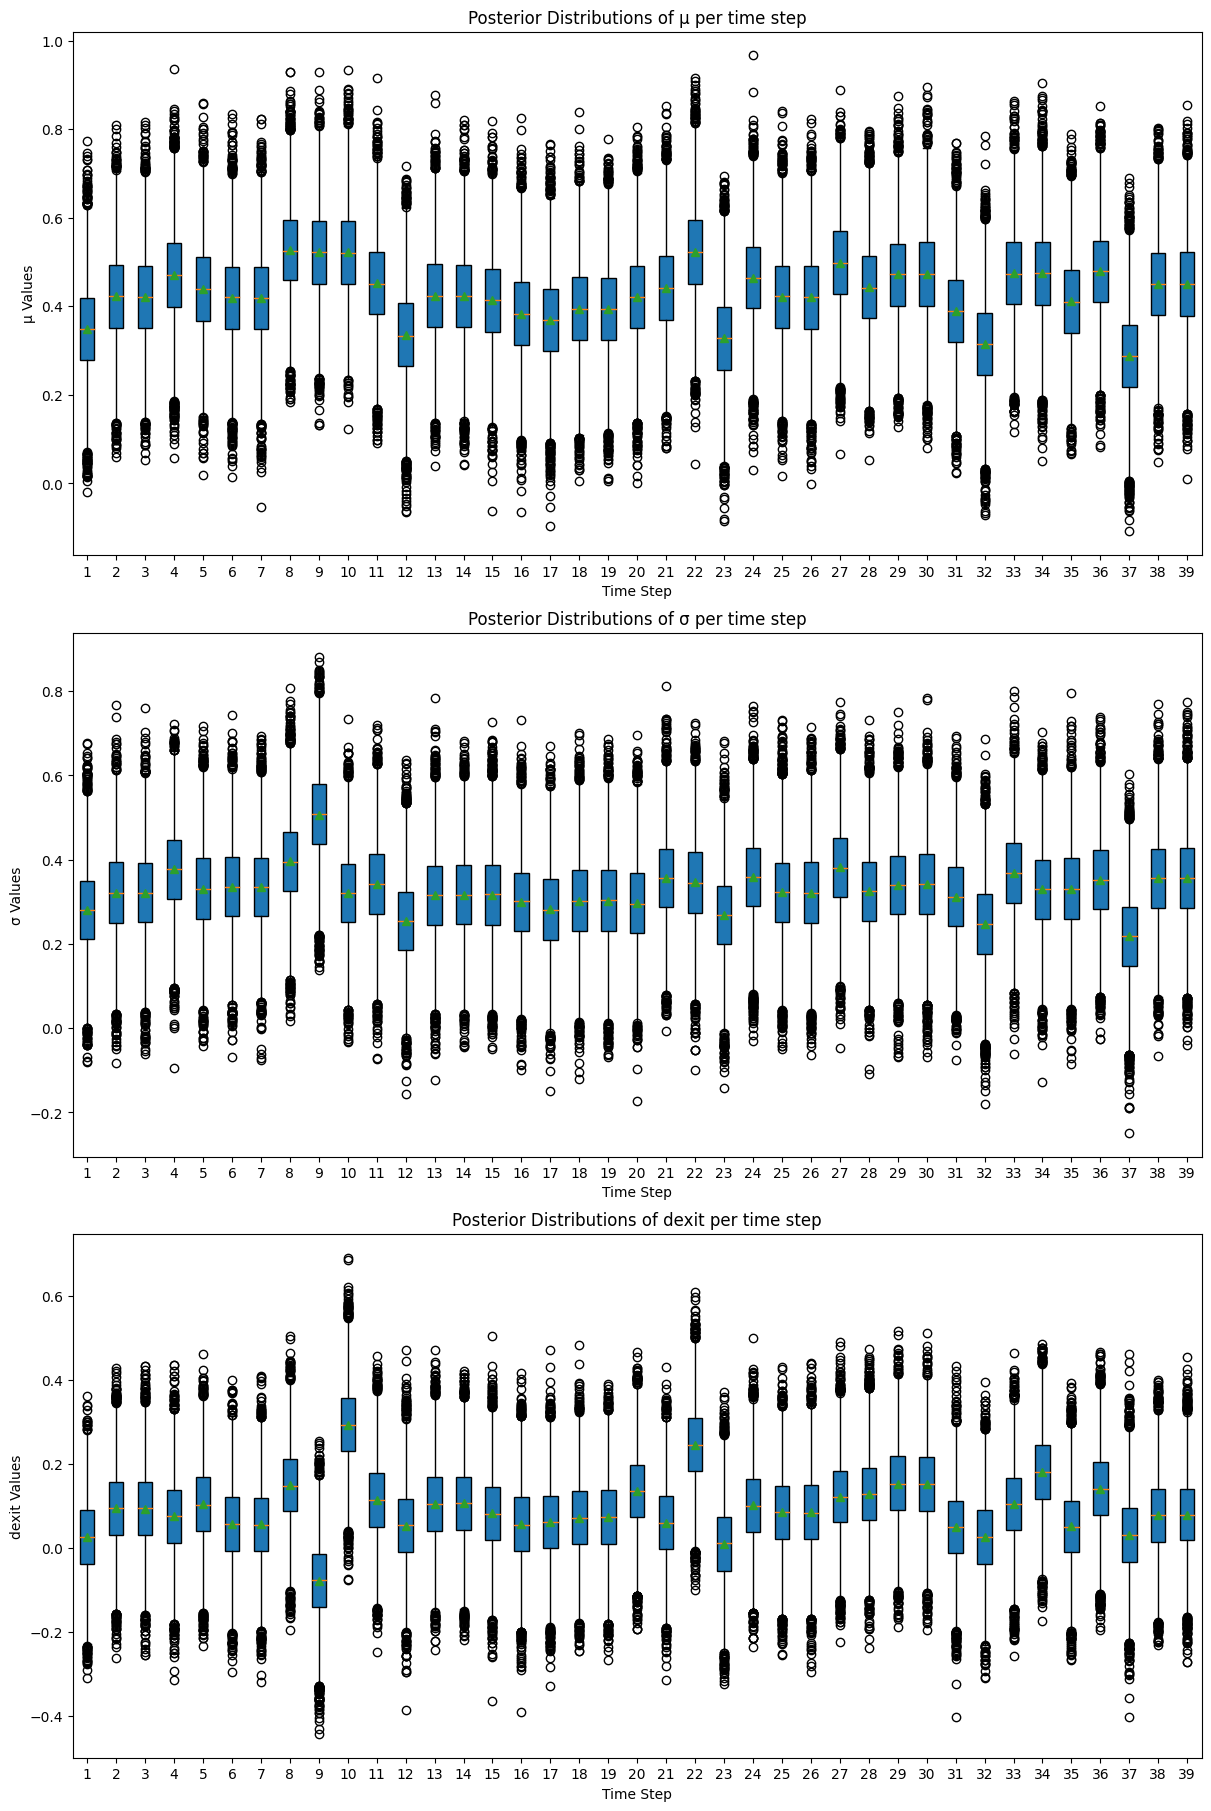

In [ ]:
import matplotlib.pyplot as plt
import arviz as az
import numpy as np

# Extract posterior samples for each parameter
mu_samples = trace.posterior["mu"].stack(samples=("chain", "draw")).values
sigma_samples = trace.posterior["sigma"].stack(samples=("chain", "draw")).values
dexit_samples = trace.posterior["dexit"].stack(samples=("chain", "draw")).values

# Number of time steps
n_steps = mu_samples.shape[0]

# Create box-whisker plots for each parameter
fig, axes = plt.subplots(3, 1, figsize=(12, 18), constrained_layout=True)

# Plot for mu
axes[0].boxplot(mu_samples.T, vert=True, patch_artist=True, showmeans=True)
axes[0].set_title("Posterior Distributions of μ per time step")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("μ Values")
axes[0].set_xticks(range(1, n_steps + 1))
axes[0].set_xticklabels(range(1, n_steps + 1))

# Plot for sigma
axes[1].boxplot(sigma_samples.T, vert=True, patch_artist=True, showmeans=True)
axes[1].set_title("Posterior Distributions of σ per time step")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("σ Values")
axes[1].set_xticks(range(1, n_steps + 1))
axes[1].set_xticklabels(range(1, n_steps + 1))

# Plot for dexit
axes[2].boxplot(dexit_samples.T, vert=True, patch_artist=True, showmeans=True)
axes[2].set_title("Posterior Distributions of dexit per time step")
axes[2].set_xlabel("Time Step")
axes[2].set_ylabel("dexit Values")
axes[2].set_xticks(range(1, n_steps + 1))
axes[2].set_xticklabels(range(1, n_steps + 1))

# Show the plots
plt.show()


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_mu,0.428,0.050,0.339,0.525,0.001,0.001,1622.0,3469.0,1.0
global_sigma,0.326,0.049,0.236,0.418,0.001,0.001,1699.0,3137.0,1.0
global_dexit,0.091,0.034,0.027,0.156,0.001,0.000,3499.0,5523.0,1.0
mu[0],0.348,0.104,0.150,0.542,0.001,0.001,5409.0,6473.0,1.0
mu[1],0.423,0.105,0.230,0.625,0.001,0.001,5929.0,6725.0,1.0
...,...,...,...,...,...,...,...,...,...
dexit[34],0.051,0.092,-0.120,0.224,0.001,0.001,12464.0,7295.0,1.0
dexit[35],0.141,0.094,-0.032,0.324,0.001,0.001,12468.0,6994.0,1.0
dexit[36],0.030,0.096,-0.146,0.216,0.001,0.001,14192.0,6157.0,1.0
dexit[37],0.077,0.093,-0.106,0.245,0.001,0.001,14430.0,6982.0,1.0


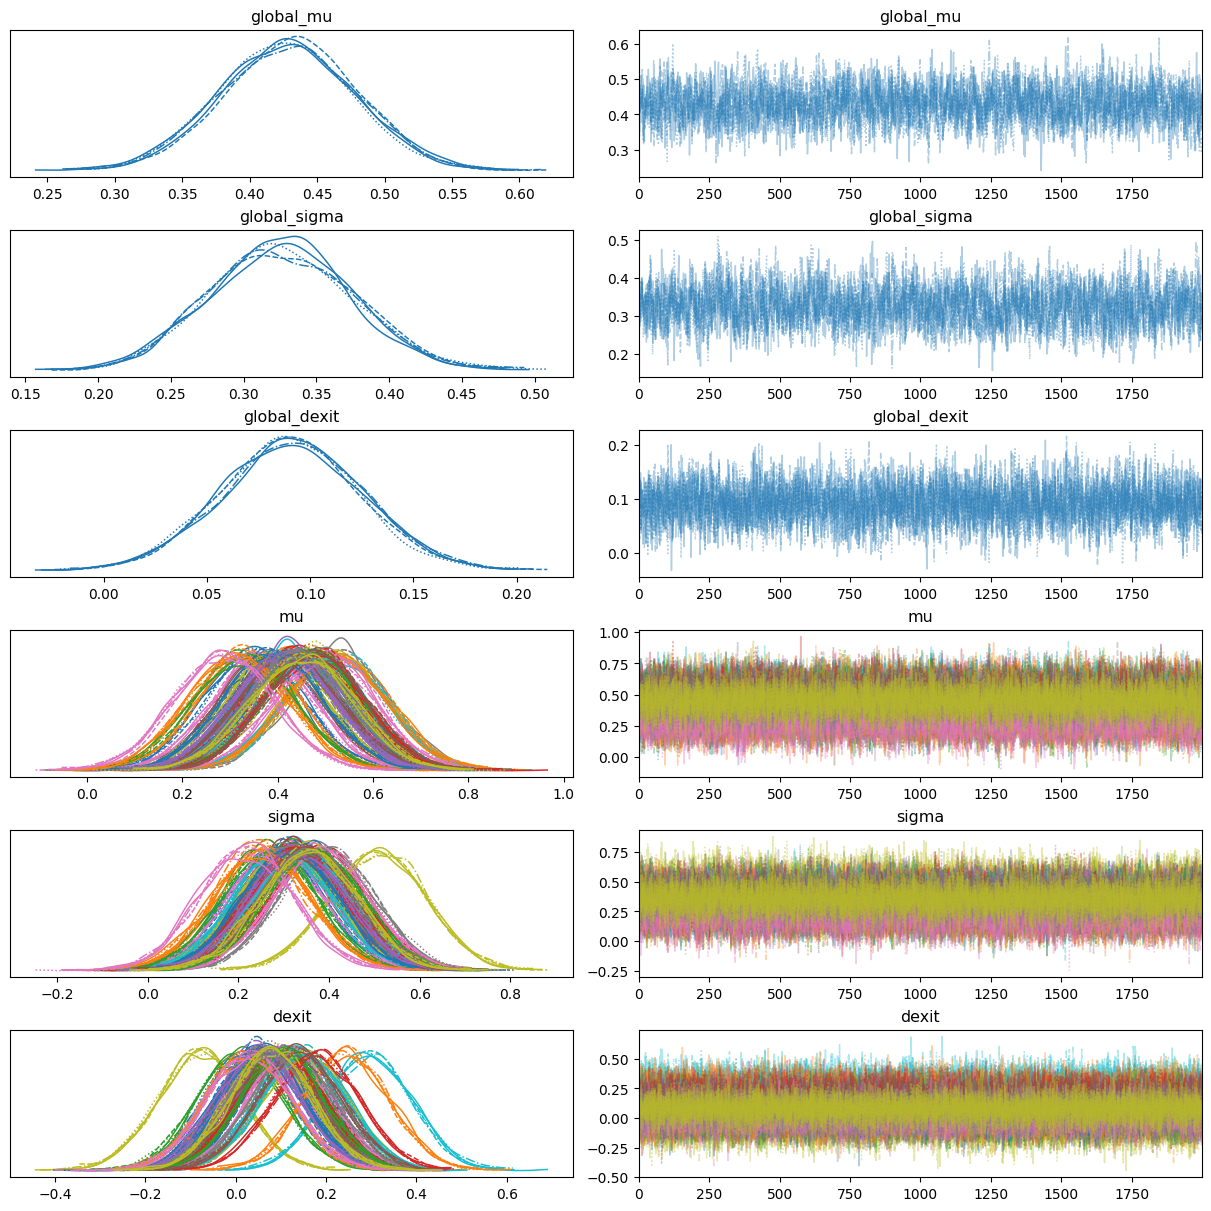

In [ ]:
plt.rcParams['figure.constrained_layout.use'] = True
az.plot_trace(trace)
az.summary(trace)

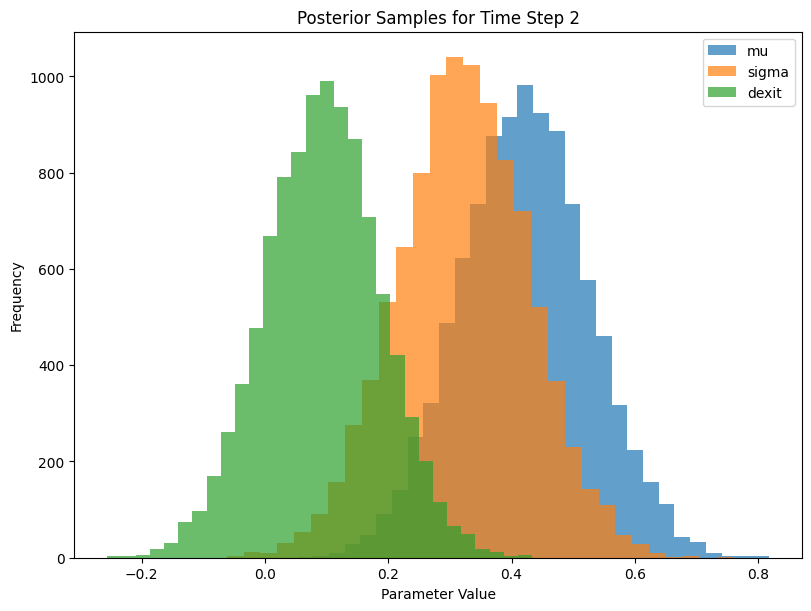

In [ ]:
# Extract posterior samples for each time step
posterior_samples = trace.posterior

# Number of samples to draw for each time step
n_samples = 10000  # Adjust this number as needed

# Initialize lists to store sampled rates for each parameter
mu_samples = []
sigma_samples = []
dexit_samples = []

# Iterate over each time step
for t in range(n_steps):
    # Extract samples for the current time step
    mu_t_samples = posterior_samples["mu"][:, :, t].values.flatten()
    sigma_t_samples = posterior_samples["sigma"][:, :, t].values.flatten()
    dexit_t_samples = posterior_samples["dexit"][:, :, t].values.flatten()

    # Randomly sample from the posterior distribution at time t
    mu_samples.append(sample(list(mu_t_samples), n_samples))
    sigma_samples.append(sample(list(sigma_t_samples), n_samples))
    dexit_samples.append(sample(list(dexit_t_samples), n_samples))

# Convert lists to NumPy arrays for further analysis or visualization
mu_samples = np.array(mu_samples)
sigma_samples = np.array(sigma_samples)
dexit_samples = np.array(dexit_samples)

# Example: Plot posterior samples for a specific time step
time_step = 2  # Choose a time step to visualize
plt.figure(figsize=(8, 6))
plt.hist(mu_samples[time_step], bins=30, alpha=0.7, label="mu")
plt.hist(sigma_samples[time_step], bins=30, alpha=0.7, label="sigma")
plt.hist(dexit_samples[time_step], bins=30, alpha=0.7, label="dexit")
plt.title(f"Posterior Samples for Time Step {time_step}")
plt.xlabel("Parameter Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [ ]:
tf = 4
tstep = n_steps
beta = 0.000
peptide_ratio = 80  # Set the peptide ratio directly
ratio_exp = 6.892
fixed_siRNA_amount = 120

exp_value = ratio_exp
initial_FP = exp_value * fixed_siRNA_amount

initial_conditions = np.array([
                  initial_FP-fixed_siRNA_amount,
                    0,
                    100-efp_in[0] ,
                    ee[0] *fixed_siRNA_amount/100 ,
                  (efp_in[0] - ee[0])*fixed_siRNA_amount/100
] , dtype=float)

print(initial_conditions)

[707.04         0.          85.29701395  12.24597391   5.39760935]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def gillespie_extended_with_posteriors(
    mu_estimates, sigma_estimates, dexit_estimates,
    initial_state, t_max, t_points
):
    A, B, C, D, E = initial_state

    times = [0]
    states = [[A, B, C, D, E]]

    while times[-1] < t_max:
        # Find the closest time step index for posterior parameters
        t_idx = np.searchsorted(t_points, times[-1], side="right") - 1

        # Use the posterior means for the current time step
        mu = mu_estimates[t_idx]
        sigma = sigma_estimates[t_idx]
        dexit = dexit_estimates[t_idx]

        # Reaction rates
        rates = [
            mu * A * B,  # A + B -> C
            0 * B,       # B -> D
            sigma * C,   # C -> D
            dexit * C    # C -> E
        ]
        total_rate = sum(rates)

        if total_rate <= 0:
            break

        # Time to next reaction
        tau = np.random.exponential(1 / total_rate)
        times.append(times[-1] + tau)

        # Determine which reaction occurs
        reaction_probabilities = np.cumsum(rates) / total_rate
        reaction_choice = np.searchsorted(reaction_probabilities, np.random.rand())

        # Stoichiometry: change in concentrations
        if reaction_choice == 0:  # A + B -> C
            A -= 1
            B -= 1
            C += 1
        elif reaction_choice == 1:  # B -> D
            pass
        elif reaction_choice == 2:  # C -> D
            C -= 1
            D += 1
        elif reaction_choice == 3:  # C -> E
            C -= 1
            E += 1

        # Enforce non-negativity constraints
        C = max(C, 0)
        D = max(D, 0)
        E = max(E, 0)

        # Enforce upper boundary (max value = 100)
        C = min(C, 100)
        D = min(D, 100)
        E = min(E, 100)

        states.append([A, B, C, D, E])

    return np.array(times), np.array(states)


# Summary statistics: Extract concentration of C, D, E
def summary_statistics(times, states, t_points, species_idx):
    species_concentration = states[:, species_idx]  # Index for C, D, or E
    return np.interp(t_points, times, species_concentration)

# Normalize data: Z-score normalization
def normalize(data):
    std = np.std(data)
    if std == 0:
        return data - np.mean(data)  # Normalize to zero mean only
    return (data - np.mean(data)) / std

def abc_extended_all_species_with_posteriors(
    observed_data, t_points, mu_estimates, sigma_estimates, dexit_estimates,
    num_simulations, tolerance, t_max, initial_state
):

    # Unpack observed data (C, D, E)
    observed_data_C, observed_data_D, observed_data_E = observed_data

    # Initialize storage for accepted parameters and simulated curves
    accepted_params = []
    accepted_simulated_C = []
    accepted_simulated_D = []
    accepted_simulated_E = []

    for simulation in range(num_simulations):

        times, states = gillespie_extended_with_posteriors(
            mu_estimates, sigma_estimates, dexit_estimates,
            initial_state=initial_state, t_max=t_max, t_points=t_points
        )

        # Compute summary statistics for each species (C, D, E)
        simulated_C = summary_statistics(times, states, t_points, species_idx=2)  # C concentrations
        simulated_D = summary_statistics(times, states, t_points, species_idx=3)  # D concentrations
        simulated_E = summary_statistics(times, states, t_points, species_idx=4)  # E concentrations

        # Normalize the observed data for D
        observed_data_D = observed_data[1]  # Extract observed data for D
        observed_data_D_interp = normalize(np.interp(t_points, np.linspace(0, t_max, len(observed_data_D)), observed_data_D))

        # Normalize the simulated data for D
        simulated_D_normalized = normalize(simulated_D)

        # Calculate distance for D
        distance_D = np.linalg.norm(simulated_D_normalized - observed_data_D_interp)

        # Accept parameters and save paths if distance for D is smaller than tolerance
        if distance_D < tolerance:
            accepted_simulated_C.append(100-simulated_C)
            accepted_simulated_D.append(simulated_D)
            accepted_simulated_E.append(simulated_E)

    # Return accepted parameters and accepted simulated curves
    return (
        np.array(accepted_simulated_C),
        np.array(accepted_simulated_D),
        np.array(accepted_simulated_E)
    )


# Load the observed data from CSV
def load_observed_data(csv_file):
    data = pd.read_csv(csv_file)
    data=data[data['Peptide Ratio'] == '80_background_edit']
    efp_in = data['EFP_in'].values
    ee = data['Endosomal Escape'].values
    efp_out = efp_in - ee
    C = efp_in  # C is the EFP_in
    D = ee      # D is the Endosomal Escape
    E = efp_out # E is the difference (efp_in - Endosomal Escape)

    # Return as tuple for C, D, E
    return C, D, E

    observed_data_E_interp = np.interp(t_points, np.linspace(0, 4, len(observed_data[2])), observed_data[2])





In [ ]:
import numpy as np

# Number of steps for the desired output
n_time_points = 39
t_points = np.linspace(0, 4, n_time_points)  # 39 evenly spaced time points from 0 to 4 hours

# Extract posterior samples for each parameter
mu_samples = trace.posterior["mu"].stack(samples=("chain", "draw")).values
sigma_samples = trace.posterior["sigma"].stack(samples=("chain", "draw")).values
dexit_samples = trace.posterior["dexit"].stack(samples=("chain", "draw")).values

# Total number of simulations and batch size
num_simulations = 6000
batch_size = 1
tolerance = 1000
t_max=4
# Main setup
if __name__ == "__main__":
    # Load the observed data from a CSV file
    csv_file = '80_dataset_with_fixed_cycles.csv'  # Replace with the path to your CSV file
    observed_data = load_observed_data(csv_file)  # Returns C, D, E as tuple

    # Initialize arrays to store simulation results
    all_simulated_C = []
    all_simulated_D = []
    all_simulated_E = []

    # Perform simulations in batches of 500
    for batch_start in range(0, num_simulations, batch_size):
        # Select new posterior samples for this batch
        random_indices = np.random.choice(mu_samples.shape[1], size=n_time_points, replace=True)

        # Generate sampled arrays for each parameter
        mu_sampled_array = np.array([mu_samples[t, random_indices[t]] for t in range(n_time_points)])
        sigma_sampled_array = np.array([sigma_samples[t, random_indices[t]] for t in range(n_time_points)])
        dexit_sampled_array = np.array([dexit_samples[t, random_indices[t]] for t in range(n_time_points)])

        # Perform ABC for this batch
        batch_simulated_C, batch_simulated_D, batch_simulated_E = abc_extended_all_species_with_posteriors(
            observed_data, t_points, mu_sampled_array, sigma_sampled_array, dexit_sampled_array,
            batch_size, tolerance, t_max, initial_conditions
        )

        # Store the batch results
        all_simulated_C.extend(batch_simulated_C)
        all_simulated_D.extend(batch_simulated_D)
        all_simulated_E.extend(batch_simulated_E)

    # Convert results to arrays
    all_simulated_C = np.array(all_simulated_C)
    all_simulated_D = np.array(all_simulated_D)
    all_simulated_E = np.array(all_simulated_E)

    # Interpolate the observed data to match t_points
    observed_data_C_interp = np.interp(t_points, np.linspace(0, 4, len(observed_data[0])), observed_data[0])
    observed_data_D_interp = np.interp(t_points, np.linspace(0, 4, len(observed_data[1])), observed_data[1])
    observed_data_E_interp = np.interp(t_points, np.linspace(0, 4, len(observed_data[2])), observed_data[2])

    # You can now proceed with further analysis


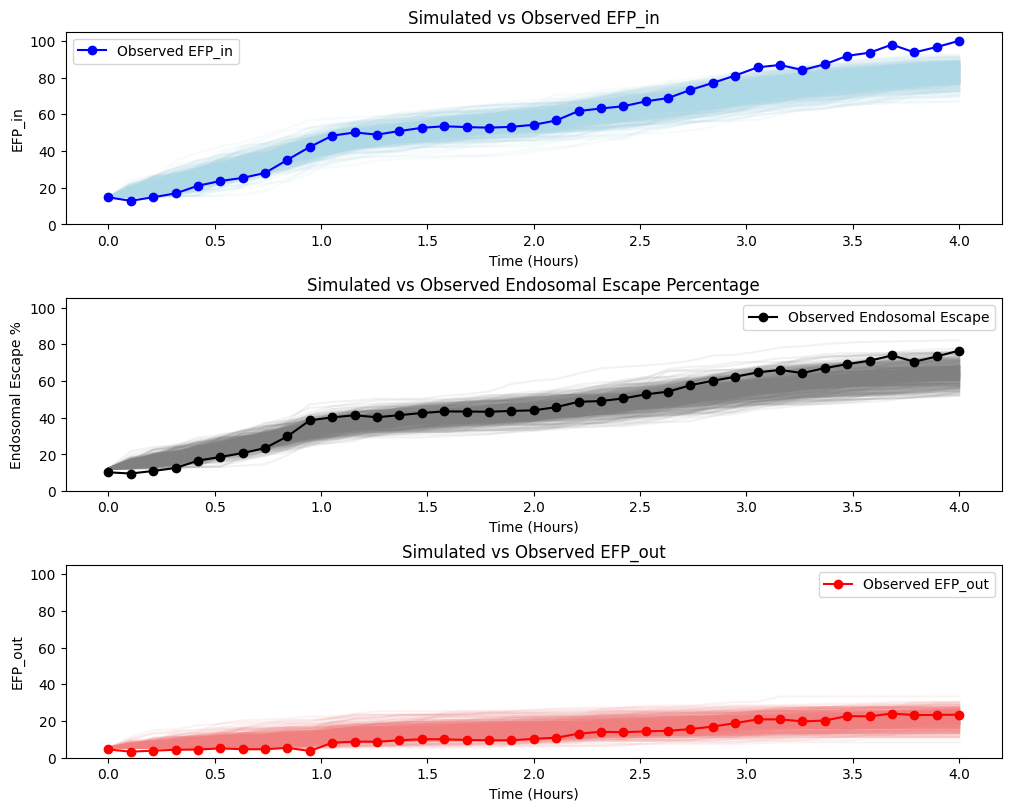

In [ ]:
    # Plot the observed and simulated curves
    plt.figure(figsize=(10,8))

    # Plot for C (EFP_in)
    plt.subplot(3, 1, 1)
    for sim in all_simulated_C:
        plt.plot(t_points, sim, color='lightblue', alpha=0.1)
    plt.plot(t_points, observed_data_C_interp, label="Observed EFP_in", marker='o', color='blue')
    plt.xlabel('Time (Hours)')
    plt.ylabel('EFP_in')
    plt.title('Simulated vs Observed EFP_in')
    plt.legend()
    plt.ylim(0, 105)

    # Plot for D (Endosomal Escape)
    plt.subplot(3, 1, 2)
    for sim in all_simulated_D:
        plt.plot(t_points, sim, color='gray', alpha=0.1)
    plt.plot(t_points, observed_data_D_interp, label="Observed Endosomal Escape", marker='o', color='black')
    plt.xlabel('Time (Hours)')
    plt.ylabel('Endosomal Escape %')
    plt.title('Simulated vs Observed Endosomal Escape Percentage')
    plt.legend()
    plt.ylim(0, 105)

    # Plot for E (efp_out)
    plt.subplot(3, 1, 3)

    for sim in all_simulated_E:
        plt.plot(t_points, sim, color='lightcoral', alpha=0.1)
    plt.plot(t_points, observed_data_E_interp, label="Observed EFP_out", marker='o', color='red')
    plt.xlabel('Time (Hours)')
    plt.ylabel('EFP_out')
    plt.title('Simulated vs Observed EFP_out')
    plt.legend()
    plt.ylim(0, 105)

    # plt.tight_layout()
    plt.show()

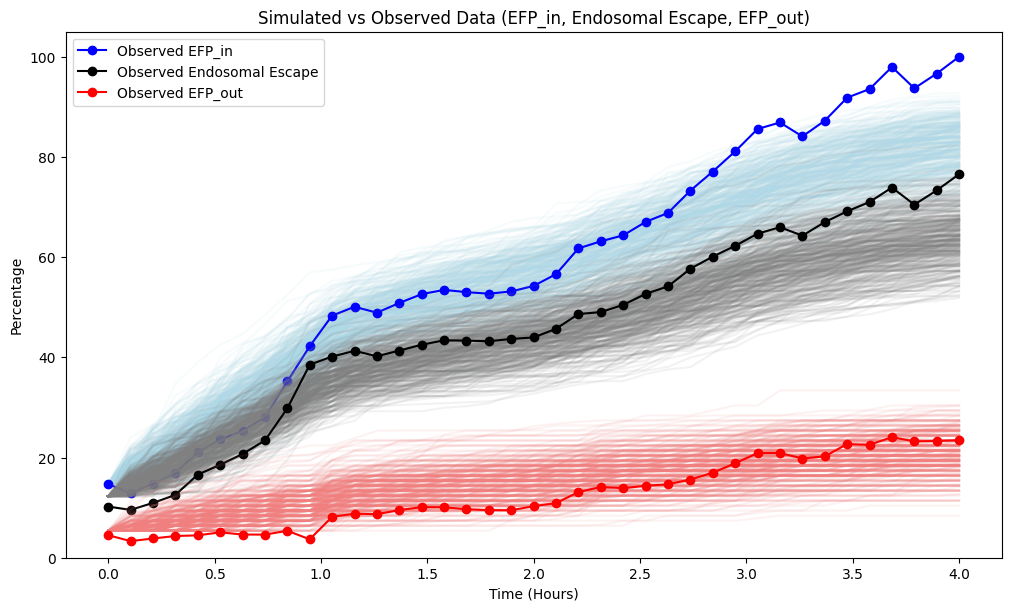

In [ ]:
# Plot the observed and simulated curves on one plot
plt.figure(figsize=(10, 6))

# Plot all simulations and observed data on the same plot

# EFP_in
for sim in all_simulated_C:
    plt.plot(t_points, sim, color='lightblue', alpha=0.1)
plt.plot(t_points, observed_data_C_interp, label="Observed EFP_in", marker='o', color='blue')

# Endosomal Escape Percentage
for sim in all_simulated_D:
    plt.plot(t_points, sim, color='gray', alpha=0.1)
plt.plot(t_points, observed_data_D_interp, label="Observed Endosomal Escape", marker='o', color='black')

# EFP_out
for sim in all_simulated_E:
    plt.plot(t_points, sim, color='lightcoral', alpha=0.1)
plt.plot(t_points, observed_data_E_interp, label="Observed EFP_out", marker='o', color='red')

# Labels and title
plt.xlabel('Time (Hours)')
plt.ylabel('Percentage')
plt.title('Simulated vs Observed Data (EFP_in, Endosomal Escape, EFP_out)')
plt.legend()

# Set the y-axis to 0-105 for all data
plt.ylim(0, 105)

# plt.tight_layout()
plt.show()


# for sensitivity analysis

In [ ]:
import numpy as np
from scipy.integrate import simps
from SALib.sample import saltelli
from SALib.analyze import sobol

# Problem definition
problem = {
    'num_vars': 3,  # mu, sigma, dexit
    'names': ['mu', 'sigma', 'dexit'],
    'bounds': [
        [np.min(mu_estimates), np.max(mu_estimates)],  # Bounds for mu
        [np.min(sigma_estimates), np.max(sigma_estimates)],  # Bounds for sigma
        [np.min(dexit_estimates), np.max(dexit_estimates)],  # Bounds for dexit
    ]
}

# Generate Sobol samples
param_values = saltelli.sample(problem, 1000)  # base samples
print(param_values)

# Time points for interpolation
t_points = np.linspace(0, 4, len(mu_estimates))

# Initialize storage for outputs
outputs_C = []  # For species C
outputs_D = []  # For species D
outputs_E = []  # For species E
auc_C = []  # AUC for species C
auc_D = []  # AUC for species D
auc_E = []  # AUC for species E

# Loop over parameter samples
for sample in param_values:
    mu, sigma, dexit = sample


    # Create constant parameter vectors
    mu_vec = np.full_like(mu_estimates, mu)
    sigma_vec = np.full_like(sigma_estimates, sigma)
    dexit_vec = np.full_like(dexit_estimates, dexit)


    # Run simulation
    times, states = gillespie_extended_with_posteriors(
        mu_vec, sigma_vec, dexit_vec,
        initial_state=initial_conditions,
        t_max=4,
        t_points=t_points
    )

    # Interpolate species concentrations at defined time points
    C = summary_statistics(times, states, t_points, species_idx=2)  # C
    D = summary_statistics(times, states, t_points, species_idx=3)  # D
    E = summary_statistics(times, states, t_points, species_idx=4)  # E

    # Store time-dependent outputs
    outputs_C.append(C)
    outputs_D.append(D)
    outputs_E.append(E)

    # Compute AUC for each species using Simpson's rule
    auc_C.append(simps(C, t_points))
    auc_D.append(simps(D, t_points))
    auc_E.append(simps(E, t_points))

# Convert outputs to arrays
outputs_C = np.array(outputs_C)
outputs_D = np.array(outputs_D)
outputs_E = np.array(outputs_E)
auc_C = np.array(auc_C)
auc_D = np.array(auc_D)
auc_E = np.array(auc_E)


/local_scratch/slurm.1761624/ipykernel_1087938/3444220922.py:18: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1000)  # base samples
/home/fnisha/.conda/envs/tf_env/lib/python3.8/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


[[ 0.28832499  0.32673101  0.08782178]
 [ 0.40400176  0.32673101  0.08782178]
 [ 0.28832499  0.37902008  0.08782178]
 ...
 [ 0.40888951  0.37223664 -0.07811777]
 [ 0.40888951  0.35499537  0.07002958]
 [ 0.40888951  0.35499537 -0.07811777]]


In [ ]:
# Time-specific sensitivity analysis for species C
time_step = 10  # Choose a specific time step
Si_C = sobol.analyze(problem, outputs_D[:, time_step], print_to_console=True)


             ST   ST_conf
mu     0.384982  0.034827
sigma  0.994998  0.083283
dexit  0.430387  0.042010
             S1   S1_conf
mu     0.000959  0.051570
sigma  0.568093  0.074354
dexit  0.009337  0.050423
                      S2   S2_conf
(mu, sigma)     0.030469  0.071799
(mu, dexit)     0.013897  0.066360
(sigma, dexit)  0.060117  0.095349


/home/fnisha/.conda/envs/tf_env/lib/python3.8/site-packages/SALib/analyze/sobol.py:220: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
/home/fnisha/.conda/envs/tf_env/lib/python3.8/site-packages/SALib/analyze/sobol.py:233: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
/home/fnisha/.conda/envs/tf_env/lib/python3.8/site-packages/SALib/analyze/sobol.py:243: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
/home/fnisha/.conda/envs/tf_env/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fnisha/.conda/envs/tf_env/lib/python3.8/site-packages/numpy/core/_methods.py:254: 

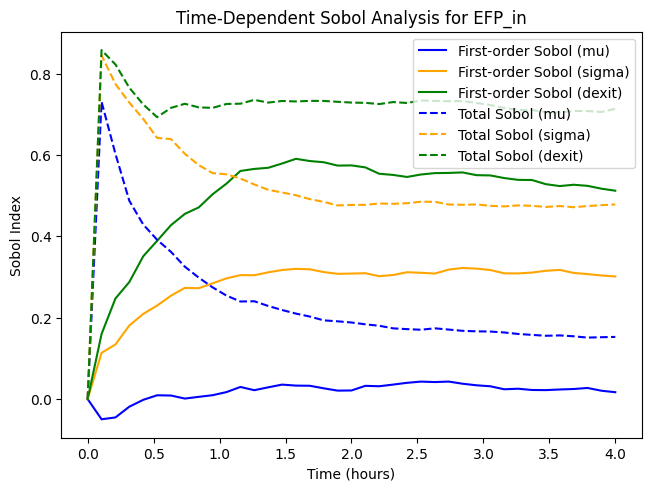

In [ ]:
import matplotlib.pyplot as plt

# Define time indices
time_indices = range(len(t_points))

# Sobol indices for species D (Endosomal Escape) across all time points
S1_mu = [sobol.analyze(problem, outputs_C[:, t])['S1'][0] for t in time_indices]  # mu (parameter 1)
S1_sigma = [sobol.analyze(problem, outputs_C[:, t])['S1'][1] for t in time_indices]  # sigma (parameter 2)
S1_dexit = [sobol.analyze(problem, outputs_C[:, t])['S1'][2] for t in time_indices]  # dexit (parameter 3)

ST_mu = [sobol.analyze(problem, outputs_C[:, t])['ST'][0] for t in time_indices]  # mu (parameter 1)
ST_sigma = [sobol.analyze(problem, outputs_C[:, t])['ST'][1] for t in time_indices]  # sigma (parameter 2)
ST_dexit = [sobol.analyze(problem, outputs_C[:, t])['ST'][2] for t in time_indices]  # dexit (parameter 3)

# Plot Sobol indices across time
plt.plot(t_points, S1_mu, label="First-order Sobol (mu)", color="blue")
plt.plot(t_points, S1_sigma, label="First-order Sobol (sigma)", color="orange")
plt.plot(t_points, S1_dexit, label="First-order Sobol (dexit)", color="green")

plt.plot(t_points, ST_mu, label="Total Sobol (mu)", linestyle="--", color="blue")
plt.plot(t_points, ST_sigma, label="Total Sobol (sigma)", linestyle="--", color="orange")
plt.plot(t_points, ST_dexit, label="Total Sobol (dexit)", linestyle="--", color="green")

# Add labels, title, and legend
plt.xlabel("Time (hours)")
plt.ylabel("Sobol Index")
plt.title("Time-Dependent Sobol Analysis for EFP_in")

plt.legend()
plt.show()


/local_scratch/slurm.1761624/ipykernel_1087938/756213424.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # To make sure everything fits within the figure


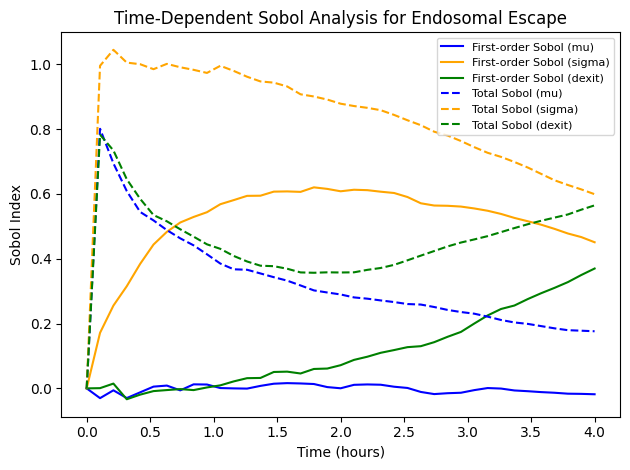

In [ ]:
import matplotlib.pyplot as plt

# Define time indices
time_indices = range(len(t_points))

# Sobol indices for species D (Endosomal Escape) across all time points
S1_mu = [sobol.analyze(problem, outputs_D[:, t])['S1'][0] for t in time_indices]  # mu (parameter 1)
S1_sigma = [sobol.analyze(problem, outputs_D[:, t])['S1'][1] for t in time_indices]  # sigma (parameter 2)
S1_dexit = [sobol.analyze(problem, outputs_D[:, t])['S1'][2] for t in time_indices]  # dexit (parameter 3)

ST_mu = [sobol.analyze(problem, outputs_D[:, t])['ST'][0] for t in time_indices]  # mu (parameter 1)
ST_sigma = [sobol.analyze(problem, outputs_D[:, t])['ST'][1] for t in time_indices]  # sigma (parameter 2)
ST_dexit = [sobol.analyze(problem, outputs_D[:, t])['ST'][2] for t in time_indices]  # dexit (parameter 3)

# Plot Sobol indices across time
plt.plot(t_points, S1_mu, label="First-order Sobol (mu)", color="blue")
plt.plot(t_points, S1_sigma, label="First-order Sobol (sigma)", color="orange")
plt.plot(t_points, S1_dexit, label="First-order Sobol (dexit)", color="green")

plt.plot(t_points, ST_mu, label="Total Sobol (mu)", linestyle="--", color="blue")
plt.plot(t_points, ST_sigma, label="Total Sobol (sigma)", linestyle="--", color="orange")
plt.plot(t_points, ST_dexit, label="Total Sobol (dexit)", linestyle="--", color="green")

# Add labels, title, and legend
plt.xlabel("Time (hours)")
plt.ylabel("Sobol Index")
plt.title("Time-Dependent Sobol Analysis for Endosomal Escape")

# Place the legend in the top-right corner with a smaller font
plt.legend(loc='upper right', fontsize=8)

# Show plot
plt.tight_layout()  # To make sure everything fits within the figure
plt.show()


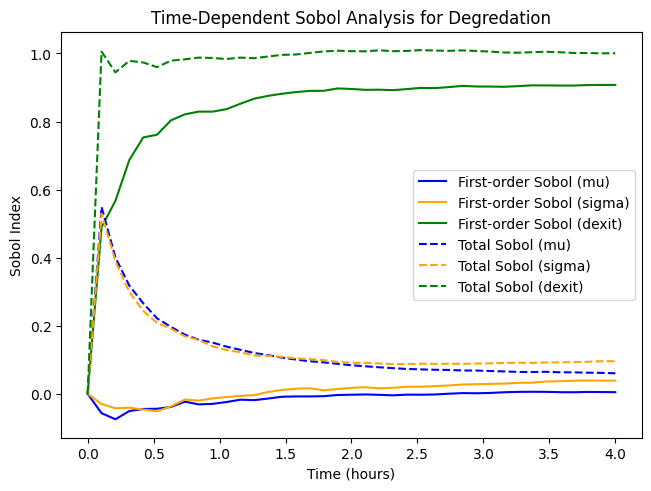

In [ ]:
import matplotlib.pyplot as plt

# Define time indices
time_indices = range(len(t_points))

# Sobol indices for species D (Endosomal Escape) across all time points
S1_mu = [sobol.analyze(problem, outputs_E[:, t])['S1'][0] for t in time_indices]  # mu (parameter 1)
S1_sigma = [sobol.analyze(problem, outputs_E[:, t])['S1'][1] for t in time_indices]  # sigma (parameter 2)
S1_dexit = [sobol.analyze(problem, outputs_E[:, t])['S1'][2] for t in time_indices]  # dexit (parameter 3)

ST_mu = [sobol.analyze(problem, outputs_E[:, t])['ST'][0] for t in time_indices]  # mu (parameter 1)
ST_sigma = [sobol.analyze(problem, outputs_E[:, t])['ST'][1] for t in time_indices]  # sigma (parameter 2)
ST_dexit = [sobol.analyze(problem, outputs_E[:, t])['ST'][2] for t in time_indices]  # dexit (parameter 3)

# Plot Sobol indices across time
plt.plot(t_points, S1_mu, label="First-order Sobol (mu)", color="blue")
plt.plot(t_points, S1_sigma, label="First-order Sobol (sigma)", color="orange")
plt.plot(t_points, S1_dexit, label="First-order Sobol (dexit)", color="green")

plt.plot(t_points, ST_mu, label="Total Sobol (mu)", linestyle="--", color="blue")
plt.plot(t_points, ST_sigma, label="Total Sobol (sigma)", linestyle="--", color="orange")
plt.plot(t_points, ST_dexit, label="Total Sobol (dexit)", linestyle="--", color="green")

# Add labels, title, and legend
plt.xlabel("Time (hours)")
plt.ylabel("Sobol Index")
plt.title("Time-Dependent Sobol Analysis for Degredation")

plt.legend()
plt.show()


# FAST Sensitivity analysis

In [ ]:
import numpy as np
from scipy.integrate import simps
from SALib.sample.fast_sampler import sample
from SALib.analyze import fast

# Problem definition
problem = {
    'num_vars': 3,  # mu, sigma, dexit
    'names': ['mu', 'sigma', 'dexit'],
    'bounds': [
        [np.min(mu_estimates), np.max(mu_estimates)],  # Bounds for mu
        [np.min(sigma_estimates), np.max(sigma_estimates)],  # Bounds for sigma
        [np.min(dexit_estimates), np.max(dexit_estimates)],  # Bounds for dexit
    ]
}

# Set M (number of grid points per parameter for FAST)
M = 100

# Generate FAST samples
param_values = sample(problem, M)

# Time points for interpolation
t_points = np.linspace(0, 4, len(mu_estimates))

# Initialize storage for outputs
outputs_C = []  # For species C
outputs_D = []  # For species D
outputs_E = []  # For species E
auc_C = []  # AUC for species C
auc_D = []  # AUC for species D
auc_E = []  # AUC for species E

# Loop over parameter samples
for sample in param_values:
    mu, sigma, dexit = sample

    # Create constant parameter vectors
    mu_vec = np.full_like(mu_estimates, mu)
    sigma_vec = np.full_like(sigma_estimates, sigma)
    dexit_vec = np.full_like(dexit_estimates, dexit)

    # Run simulation
    times, states = gillespie_extended_with_posteriors(
        mu_vec, sigma_vec, dexit_vec,
        initial_state=initial_conditions,
        t_max=4,
        t_points=t_points
    )

    # Interpolate species concentrations at defined time points
    C = summary_statistics(times, states, t_points, species_idx=2)  # C
    D = summary_statistics(times, states, t_points, species_idx=3)  # D
    E = summary_statistics(times, states, t_points, species_idx=4)  # E

    # Store time-dependent outputs
    outputs_C.append(C)
    outputs_D.append(D)
    outputs_E.append(E)

    # Compute AUC for each species using Simpson's rule
    auc_C.append(simps(C, t_points))
    auc_D.append(simps(D, t_points))
    auc_E.append(simps(E, t_points))

# Convert outputs to arrays
outputs_C = np.array(outputs_C)
outputs_D = np.array(outputs_D)
outputs_E = np.array(outputs_E)
auc_C = np.array(auc_C)
auc_D = np.array(auc_D)
auc_E = np.array(auc_E)

# Perform FAST analysis
# Example: Analyze outputs_C for a specific time step
time_step = 10
Si_C = fast.analyze(
    problem,
    outputs_C[:, time_step],  # Use model outputs for a specific time step
    M=M  # Number of grid points
)

# Analyze AUC if desired
Si_auc_C = fast.analyze(
    problem,
    auc_C,  # Use AUC values as output
    M=M
)


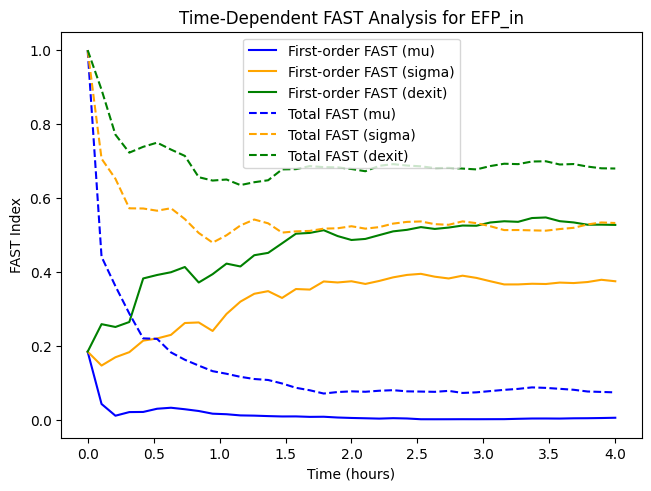

In [ ]:
import matplotlib.pyplot as plt
from SALib.analyze import fast  # Import FAST analysis

# Define time indices
time_indices = range(len(t_points))

# FAST analysis for species D (Endosomal Escape) across all time points
S1_mu = [fast.analyze(problem, outputs_C[:, t])['S1'][0] for t in time_indices]  # mu (parameter 1)
S1_sigma = [fast.analyze(problem, outputs_C[:, t])['S1'][1] for t in time_indices]  # sigma (parameter 2)
S1_dexit = [fast.analyze(problem, outputs_C[:, t])['S1'][2] for t in time_indices]  # dexit (parameter 3)

ST_mu = [fast.analyze(problem, outputs_C[:, t])['ST'][0] for t in time_indices]  # mu (parameter 1)
ST_sigma = [fast.analyze(problem, outputs_C[:, t])['ST'][1] for t in time_indices]  # sigma (parameter 2)
ST_dexit = [fast.analyze(problem, outputs_C[:, t])['ST'][2] for t in time_indices]  # dexit (parameter 3)

# Plot FAST indices across time
plt.plot(t_points, S1_mu, label="First-order FAST (mu)", color="blue")
plt.plot(t_points, S1_sigma, label="First-order FAST (sigma)", color="orange")
plt.plot(t_points, S1_dexit, label="First-order FAST (dexit)", color="green")

plt.plot(t_points, ST_mu, label="Total FAST (mu)", linestyle="--", color="blue")
plt.plot(t_points, ST_sigma, label="Total FAST (sigma)", linestyle="--", color="orange")
plt.plot(t_points, ST_dexit, label="Total FAST (dexit)", linestyle="--", color="green")

# Add labels, title, and legend
plt.xlabel("Time (hours)")
plt.ylabel("FAST Index")
plt.title("Time-Dependent FAST Analysis for EFP_in")

plt.legend()
plt.show()


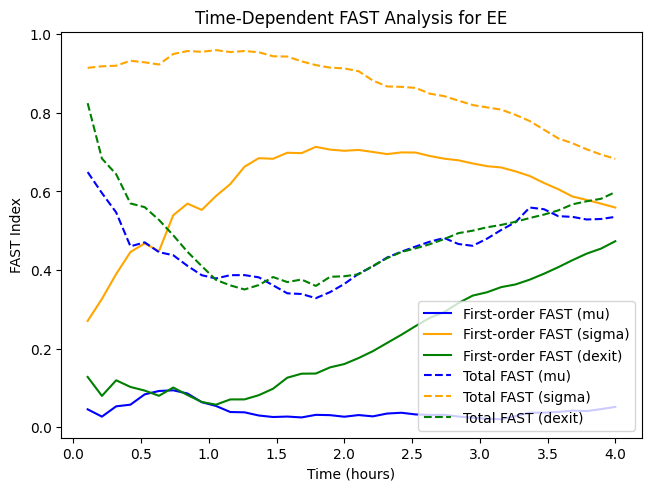

In [ ]:
import matplotlib.pyplot as plt
from SALib.analyze import fast  # Import FAST analysis

# Define time indices
time_indices = range(len(t_points))

# FAST analysis for species D (Endosomal Escape) across all time points
S1_mu = [fast.analyze(problem, outputs_D[:, t])['S1'][0] for t in time_indices]  # mu (parameter 1)
S1_sigma = [fast.analyze(problem, outputs_D[:, t])['S1'][1] for t in time_indices]  # sigma (parameter 2)
S1_dexit = [fast.analyze(problem, outputs_D[:, t])['S1'][2] for t in time_indices]  # dexit (parameter 3)

ST_mu = [fast.analyze(problem, outputs_D[:, t])['ST'][0] for t in time_indices]  # mu (parameter 1)
ST_sigma = [fast.analyze(problem, outputs_D[:, t])['ST'][1] for t in time_indices]  # sigma (parameter 2)
ST_dexit = [fast.analyze(problem, outputs_D[:, t])['ST'][2] for t in time_indices]  # dexit (parameter 3)

# Plot FAST indices across time
plt.plot(t_points, S1_mu, label="First-order FAST (mu)", color="blue")
plt.plot(t_points, S1_sigma, label="First-order FAST (sigma)", color="orange")
plt.plot(t_points, S1_dexit, label="First-order FAST (dexit)", color="green")

plt.plot(t_points, ST_mu, label="Total FAST (mu)", linestyle="--", color="blue")
plt.plot(t_points, ST_sigma, label="Total FAST (sigma)", linestyle="--", color="orange")
plt.plot(t_points, ST_dexit, label="Total FAST (dexit)", linestyle="--", color="green")

# Add labels, title, and legend
plt.xlabel("Time (hours)")
plt.ylabel("FAST Index")
plt.title("Time-Dependent FAST Analysis for EE")

plt.legend()
plt.show()


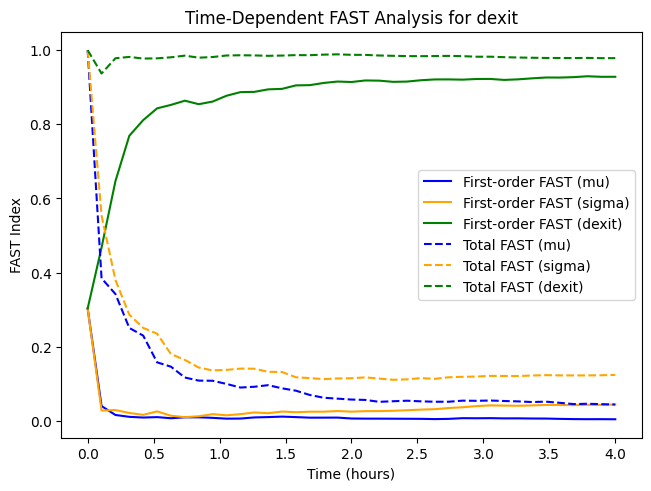

In [ ]:
import matplotlib.pyplot as plt
from SALib.analyze import fast  # Import FAST analysis

# Define time indices
time_indices = range(len(t_points))

# FAST analysis for species D (Endosomal Escape) across all time points
S1_mu = [fast.analyze(problem, outputs_E[:, t])['S1'][0] for t in time_indices]  # mu (parameter 1)
S1_sigma = [fast.analyze(problem, outputs_E[:, t])['S1'][1] for t in time_indices]  # sigma (parameter 2)
S1_dexit = [fast.analyze(problem, outputs_E[:, t])['S1'][2] for t in time_indices]  # dexit (parameter 3)

ST_mu = [fast.analyze(problem, outputs_E[:, t])['ST'][0] for t in time_indices]  # mu (parameter 1)
ST_sigma = [fast.analyze(problem, outputs_E[:, t])['ST'][1] for t in time_indices]  # sigma (parameter 2)
ST_dexit = [fast.analyze(problem, outputs_E[:, t])['ST'][2] for t in time_indices]  # dexit (parameter 3)

# Plot FAST indices across time
plt.plot(t_points, S1_mu, label="First-order FAST (mu)", color="blue")
plt.plot(t_points, S1_sigma, label="First-order FAST (sigma)", color="orange")
plt.plot(t_points, S1_dexit, label="First-order FAST (dexit)", color="green")

plt.plot(t_points, ST_mu, label="Total FAST (mu)", linestyle="--", color="blue")
plt.plot(t_points, ST_sigma, label="Total FAST (sigma)", linestyle="--", color="orange")
plt.plot(t_points, ST_dexit, label="Total FAST (dexit)", linestyle="--", color="green")

# Add labels, title, and legend
plt.xlabel("Time (hours)")
plt.ylabel("FAST Index")
plt.title("Time-Dependent FAST Analysis for dexit")

plt.legend()
plt.show()
